# Vader Sentiment Analysis
This notebook takes you through doing sentiment analysis of tweets and producing a bar graph displaying your results at the end.

For more information about how Vader works behind the scenes see here: https://github.com/cjhutto/vaderSentiment

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:     

- **nltk:** Platform for building Python programs to work with human language data. Here we bring in the VADER sentiment analysis tool which is now a part of the nltk package.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **os:** This module provides a portable way of using operating system dependent functionality.

- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

- **zipfile:** Allows for handling of zipfiles.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers, dict, list, set, and tuple.

- **math:** Provides access to the mathematical functions defined by the C standard.

Notice we import some of the packages differently. In some cases we just import the entire package when we say `import XYZ`. For some packages which are small, or, from which we are going to use a lot of the functionality it provides, this is fine. 

Sometimes when we import the package directly we say `import XYZ as X`. All this does is allow us to type `X` instead of `XYZ` when we use certain functions from the package. So we can now say `X.function()` instead of `XYZ.function()`. This saves time typing and eliminates errors from having to type out longer package names. I could just as easily type `import XYZ as potato` and whenever I use a function from the `XYZ` package I would need to type `potato.function()`. What we import the package as is up to you, but some commonly used packages have abbreviations that are standard amongst Python users such as `import pandas as pd` or `import matplotlib.pyplot as plt`. You do not need to us `pd` or `plt`, however, these are widely used and using something else could confuse other users and is generally considered bad practice. 

Other times we import only specific elements or functions from a package. This is common with packages that are very large and provide a lot of functionality, but from which we are only using a couple functions or a specific subset of the package that contains the functionality we need. This is seen when we say `from XYZ import ABC`. This is saying I only want the `ABC` function from the `XYZ` package. Sometimes we need to point to the specific location where a function is located within the package. We do this by adding periods in between the directory names, so it would look like `from XYZ.123.A1B2 import LMN`. This says we want the `LMN` function which is located in the `XYZ` package and then the `123` and `A1B2` directory in that package. 

You can also import more than one function from a package by separating the functions with commas like this `from XYZ import ABC, LMN, QRS`. This imports the `ABC`, `LMN` and `QRS` functions from the `XYZ` package.

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import os
import glob
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
import math

### Variables
Here we create some variables for use later in our code. We do this to minimize the number and complexity of the changes you will need to make later.

First we need to decide if we want to read in one file or a whole directory of files. If you want to read in a whole directory then set `source` equal to `"*"` as this is what is called a regular expression that means 'all'. So we are reading in 'all' the files in a directory. If you wish to read in a single file then set `source` equal to the name of the desired file in quotes, but leaving the '.json' or '.csv' off at the end. So a single file should look like this: `source = "myFileName"`.

Next we assign the file type our data comes in to a variable. At the moment the only options are '.csv' or '.json' as these are the most popular twitter data formats. We assign the format to the `fileType` variable. It should look like this: `fileType = ".json"`.

The `textColIndex` variable is where we put the header name of the dataframe column that will contain the content we are interested in from our tweets. Generally the content of the tweets are labeled as "text" since this is the label given to the tweet content when it is pulled directly from the Twitter API. For this reason our default value assigned to the `textColIndex` is `"text"`. If for some reason the tweet content has a different label or header, and you need to change this, remember to keep the quotes around the new label.

The variable `encoding` is where you determine what type of encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to utf-8 at the moment as we have found it is less likely to have any problems.

The remaining variables should not need to be changed. The variable `scores` is an empty list that will have data added to it further down in the code. The variables `total`, `numberOfTweets`, and `totalSquared` are variables used for counting which is why 0 is assigned to them since we generally start with nothing when counting.

In [3]:
source = "iranTweets"
fileType = ".json"
textColIndex = "text"
encoding = "utf-8"
scores = []
total = 0
numberOfTweets = 0
totalSquared = 0

### File paths
Here we assign file paths we will need throughout this notebook to variables. This way we only need to make changes here and they will be implemeneted throughout the code. The `homePath` variable uses the `environ` function from the `os` package. This function points to your home directory no matter your operating system (Linux, osX, Windows).

Then we join the `homePath` variable to folders that point to where our data is stored and we assign this file path to the variable `dataHome`. The folder names are in quotes and separated by a comma. 

Finally, we again use the `homePath` variable and join it with a file path that points to a folder where we can save any output. We assign this file path to a variable called `dataResults`.

You can change any of these to better match where your data can be found (`dataHome`) and where you want any output such as '.csv' files or images to be saved (`dataResults`).

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master","data","twitter")
dataResults = os.path.join(homePath,"Text-Analysis-master","Output")

#### Shorten SentimentIntensityAnalyzer Function

We shorten the `SentimentIntensityAnalyzer()` to the variable `vader`.

In [5]:
vader = SentimentIntensityAnalyzer()

### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you do't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

The only changes you may wish to make are in the first two lines after `if fileType == ".csv":` (if you set `fileType` equal to `".csv"` above) or the first two lines after `else:` (if you set `fileType` equal to `".json"` up above. These are the lines that point to the file paths where your '.zip' files are stored. If you have '.zip' files stored in another folder you will want to change the path. Note that the first line points to the directory and the second line points to the files.  

In [6]:
if fileType == ".csv":
    direct = os.path.join(dataHome, "CSV", "Iran")
    allZipFiles = glob.glob(os.path.join(dataHome, "CSV", "Iran","*.zip"))
    for item in allZipFiles:
            fileName = os.path.splitext(direct)[0]
            zipRef = zipfile.ZipFile(item, "r")
            zipRef.extractall(fileName)
            zipRef.close()
            os.remove(item)
else:
    direct = os.path.join(dataHome, "JSON")
    allZipFiles = glob.glob(os.path.join(dataHome, "JSON","*.zip"))
    for item in allZipFiles:
            fileName = os.path.splitext(direct)[0]
            zipRef = zipfile.ZipFile(item, "r")
            zipRef.extractall(fileName)
            zipRef.close()
            os.remove(item)

### Reading in .csv and .json files

If you chose `".csv"` as your `fileType` up above, then the first `if` statement in the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have an identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cdf` so we can use it later.

Now we convert our `cdf` to a pandas dataframe. This allows for easier manipulation of the data in the next line.

Finally, we pull in the column containing the data we are interested in which we assigned to the variable `textColIndex` earlier and turn it into a list assigned to the variable `tweets`.

If you chose `".json"` for your fileType, then the second `if` statement will read in ".json" files and save the content to a dataframe using the Pandas package much like the ".csv" file process described above. The only difference is that we use the Pandas function `read_json` instead of `read_csv`. Everything else is exactly the same as what is described above in the ".csv" section. 

In [7]:
if fileType == ".csv":
    allFiles = glob.glob(os.path.join(dataHome, "CSV", "Iran", source + fileType))     
    df = (pd.read_csv(f, engine = "python") for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf)
    tweets = cdf[textColIndex].values.tolist()
if fileType == ".json":
    allFiles = glob.glob(os.path.join(dataHome, "JSON", source + fileType))     
    df = (pd.read_json(f, encoding = encoding) for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf)
    tweets = cdf[textColIndex].values.tolist()

Now we check to see if we have pulled our tweets from our dataset. We are just checking the first 10 tweets. If you wish to see more change the 10 in the parantheses to the number of tweets you wish to see. If you wish to see the last 10 tweets then change `rtDF.head(10)` to `rtDF.tail(10)`.

In [8]:
rtDF = pd.DataFrame(tweets)
rtDF.head(10)

,0
0,Many rumours are reported now still they are r...
1,#Trump #Incompetence #Iran #Iraq #IranNuclearD...
2,America & Israel Have Been Waging A Secret War...
3,BREAKING: 4 Iranian Rockets Slam Baghdad Airpo...
4,Hearing some good news that this was Iraqi mil...
5,#BreakingNews #NewsAlert #Newsnight #Baghdadgh...
6,#40- #Iran backed militant officials that we k...
7,Make no mistake there is no proxy war in #Iraq...
8,Iraq Must Uphold Its Responsibility To Keep U....
9,"If the Iranian ""guests"" killed at Baghdad Airp..."


#### Create labels for different sentiment values and start the count for each value at zero
Here we create the labels for our different sentiment values by creating a dictionary. The number in quotes is the "key" and the integer after the colon is the value. Our sentiment scores can be anywhere from -1 to 1 with -1 having a very negative sentiment and 1 having a very positive sentiment. We assign this dictionary to the variable `res`.

In [9]:
res = {"-1":0, "-.9":0, "-.8":0, "-.7":0, "-.6":0, "-.5":0, "-.4":0, "-.3":0, "-.2":0, "-.1":0, "0":0, ".1":0, ".2":0,".3":0, ".4":0, ".5":0, ".6":0, ".7":0, ".8":0, ".9":0, "1":0}

#### Go through and apply the Vader sentiment analyzer to all tweets and count them

Here we apply VADER to our tweets and start adding the results to the `res` dictionary as well as the `total`, `numberOfTweets`, `totalSquared`, and `scores` variables. No changes should be needed here.

In [10]:
for index, row in rtDF.iterrows():
    vs = vader.polarity_scores(str(rtDF.iloc[:,0][index]))
    scores.append(vs['compound'])
    total += vs["compound"]
    numberOfTweets += 1
    totalSquared += vs["compound"]**2
    if vs["compound"]==0.0:
        res["0"] +=1
    elif 0 < vs["compound"] <= 0.1:
        res[".1"] +=1
    elif 0.1 <= vs["compound"] <= 0.2:
        res[".2"] +=1
    elif 0.2 < vs["compound"] <= 0.3:
        res[".3"] +=1
    elif 0.3 < vs["compound"] <= 0.4:
        res[".4"] +=1
    elif 0.4 < vs["compound"] <= 0.5:
        res[".5"] +=1
    elif 0.5 < vs["compound"] <= 0.6:
        res[".6"] +=1
    elif 0.6 < vs["compound"] <= 0.7:
        res[".7"] +=1
    elif 0.7 < vs["compound"] <= 0.8:
        res[".8"] +=1
    elif 0.8 < vs["compound"] <= 0.9:
        res[".9"] +=1
    elif 0.9 < vs["compound"] <= 1:
        res["1"] +=1
    elif 0 > vs["compound"] >= -0.1:
        res["-.1"] +=1
    elif -0.1 > vs["compound"] >= -0.2:
        res["-.2"] +=1
    elif -0.2 > vs["compound"] >= -0.3:
        res["-.3"] +=1
    elif -0.3 > vs["compound"] >= -0.4:
        res["-.4"] +=1
    elif -0.4 > vs["compound"] >= -0.5:
        res["-.5"] +=1
    elif -0.5 > vs["compound"] >= -0.6:
        res["-.6"] +=1
    elif -0.6 > vs["compound"] >= -0.7:
        res["-.7"] +=1
    elif -0.7 > vs["compound"] >= -0.8:
        res["-.8"] +=1
    elif -0.8 > vs["compound"] >= -0.9:
        res["-.9"] +=1
    elif -0.9 > vs["compound"] >= -1:
        res["-1"] +=1

print(res)



{'-1': 1329, '-.9': 1992, '-.8': 1688, '-.7': 1432, '-.6': 1626, '-.5': 1312, '-.4': 949, '-.3': 873, '-.2': 598, '-.1': 362, '0': 3538, '.1': 408, '.2': 433, '.3': 658, '.4': 823, '.5': 1013, '.6': 847, '.7': 674, '.8': 587, '.9': 471, '1': 199}


Now we use the math package to calcualte the `mean` and the standard deviation (`std`) of our sentiment scores.

In [11]:
mean = total / numberOfTweets
std = math.sqrt(totalSquared / numberOfTweets) - mean**2

Here we save the results of the `mean`, `std`, and `numberOfTweets` as a text file. The only changes you will need to make are to the file name in the first line. This is the name you would like to use to save your .txt file.

In [12]:
with open(os.path.join(dataResults, 'VADERCombinedRawData.txt'), 'w') as write_file:
    write_file.write(str(res))
    write_file.write("\nMean: " + str(mean))
    write_file.write("\nStandard Deviation: " + str(std))
    write_file.write("\nNumber of Tweets: " +str(numberOfTweets))

### Plot the graph

Here we plot the graph. We begin by assigning important parameters to variables. This allows you to make necessary changes and adjustments in one place without having to search through the code.

To start we assign some values regarding our output file to some variables. First, we assign the file name for our '.png' image output file to the variable `vaderBarOutput`. You may wish to change the file name to better fit your dataset. Then we assign a file format to the variable `fmt`. You may change this to '.jpg' or even '.svg', but remember to change the file type in the file name assigned to `vaderBarOutput` just before it. Now we choose the resolution of our output file and assign it to the variable `dpi`.

Now we choose a color for the bars of our bar graph. We assign the color to the variable `color`. It is currently set to `['red']`, but you can adjust it to better fit your needs.

Next we choose a figure size and assign it to the variable `figSz`. The first number in the parantheses is the width, followed by the height.

Next we choose some font sizes. The `labelFont` is where we assign the font size for the x and y axis as well as the main title. The `tickFont` variable is where we assign the font size for the ticks on the x axis. The `fontPct` is where we set the font size for the percentage markers above the each bar in the graph.

Then we choose some labels for our graph. Remember to always put the label in quotes so it is marked as a string. The `labelX` variable is where we assign a title for the x axis of the graph. The `labelY` variable is where we assign a title for the y axis (left side) of the graph. The `labelTitle` is where we assign the main title of the graph. Notice the `\n'+ 'Mean = {0:.2f}'.format(mean) + ', ' + 'Std = {0:.2f}'.format(std) +', ' + "Number of Tweets = {:,}".format(numberOfTweets)` in the title. This puts the results of the mean, standard deviation, and number of tweets in the title.

The `rotate` variable is where we set the angle of rotation of the percent labels over the bars of the bar graph. We currently have the rotation set to 45 degrees, but this may not work for your dataset, so feel free to adjust it if needed.

Now run the code and plot your graph!

   score  count
0     -1   1329
1    -.9   1992
2    -.8   1688
3    -.7   1432
4    -.6   1626
5    -.5   1312
6    -.4    949
7    -.3    873
8    -.2    598
9    -.1    362
10     0   3538
11    .1    408
12    .2    433
13    .3    658
14    .4    823
15    .5   1013
16    .6    847
17    .7    674
18    .8    587
19    .9    471
20     1    199


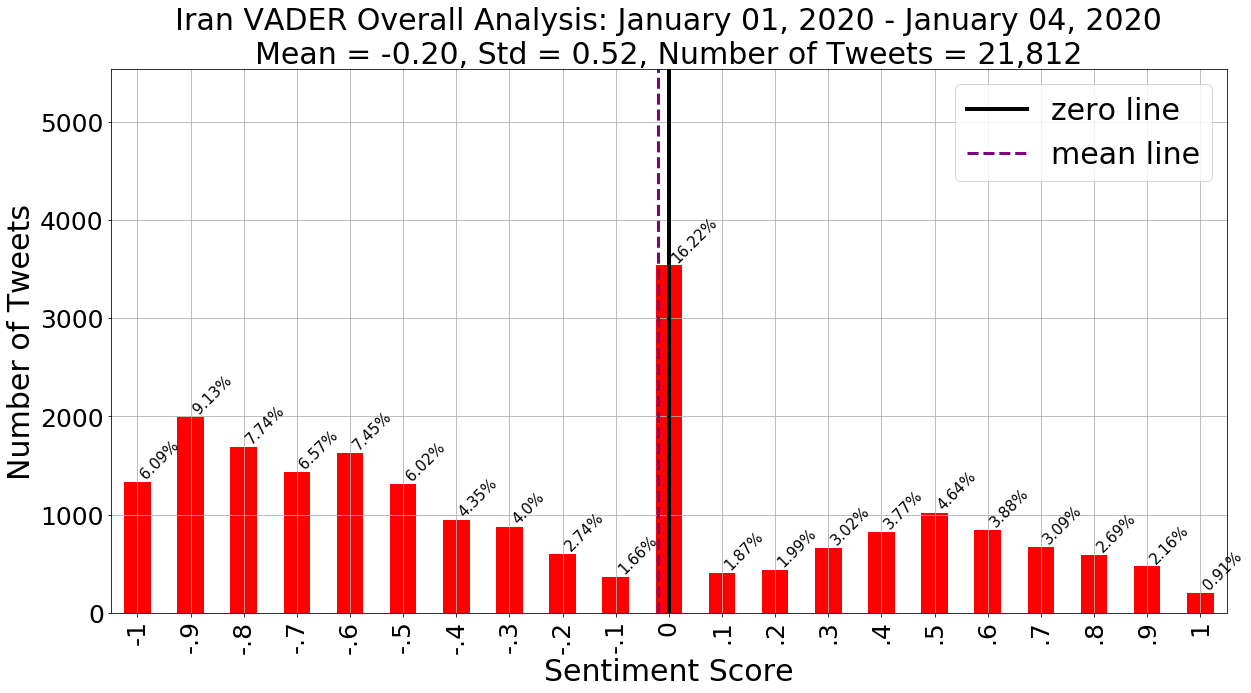

In [13]:
# Variables
vaderBarOutput = 'vaderBarGraph.png'
fmt = 'png'
dpi = 300
color = ['red']
figSz = (20,10)
fontLabel = 30
fontTick = 25
fontPct = 15
labelX = 'Sentiment Score'
labelY = 'Number of Tweets'
labelTitle = 'Iran VADER Overall Analysis: January 01, 2020 - January 04, 2020\n'
rotate = 45

# Plot graph   
%matplotlib inline
cres = Counter(res)
resdf = pd.DataFrame.from_dict(cres, orient='index').reset_index()
resdf = resdf.rename(columns={'index':'score', 0:'count'})
total = resdf['count'].sum()

print(resdf)

fig = resdf.plot(x='score',kind='bar', align = 'center', color = color, grid = True, legend = None, figsize=figSz)
fig.set_ylabel(labelY, fontsize = fontLabel)
fig.set_xlabel(labelX, fontsize = fontLabel)
fig.set_title(labelTitle + 'Mean = {0:.2f}'.format(mean) + ', ' + 'Std = {0:.2f}'.format(std) +', ' + "Number of Tweets = {:,}".format(numberOfTweets),fontsize = fontLabel)
fig.set_ylim(0,2000 + max(res.values()))

rects = fig.patches

# vertical line for 0
zeroLine = plt.axvline(x = 10, color = 'black', linewidth = 4)

# vertical line for mean
meanLine = plt.axvline(x = mean+10, color = 'purple', linestyle = 'dashed', linewidth = 3)

plt.legend((zeroLine, meanLine), ['zero line', 'mean line'], prop={'size' : fontLabel}, loc = 'upper right')

# Now make some labels

plt.tick_params(axis = 'both', which = 'major', labelsize = fontTick)

labels =round((resdf['count']/total) * 100, 2).astype(str)+'%'

for rect, label in zip(rects, labels):
    height = rect.get_height()
    fig.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='left', fontsize = fontPct, va='bottom', rotation = rotate)
    
plt.savefig(os.path.join(dataResults,vaderBarOutput), format=fmt, dpi=dpi, bbox_inches='tight')

plt.show()

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

## VOILA!!